# Document Clustering

Clustering is one of the most important Unsupervised Machine Learning Techniques. These algorithms come in handy, especially in situations where labelled data is a luxury. Clustering techniques help us understand the underlying patterns in data (more so around them being similar) along with the ability to bootstrap certain supervised learning approaches as well.



Clustering techniques have been studied in depth over the years and there are some very powerful clustering algorithms available. For this tutorial, we will be working with a movie dataset containing movie plot, cast, genres and related other information. We will be working with __K-Means__ and __Affinity Propagation__ methods.

#### __Import important packages__

In [7]:
import pandas as pd
import numpy as np
import sys 

# Text processing
from normalization import normalize_corpus
from utils import build_feature_matrix

# K-Means Clustering
from sklearn.cluster import KMeans
# Affinity Propagation
from sklearn.cluster import AffinityPropagation

from collections import Counter

# Plotting tools
import matplotlib.pyplot as plt 
# Multi-dimensional scaling
from sklearn.manifold import MDS 
# Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

#### __Load Dataset__

In [8]:
movie_data = pd.read_csv('./data/movie_data.csv')
print(movie_data.head())

                      Title                                           Synopsis
0             The Godfather  In late summer 1945, guests are gathered for t...
1  The Shawshank Redemption  In 1947, Andy Dufresne (Tim Robbins), a banker...
2          Schindler's List  The relocation of Polish Jews from surrounding...
3               Raging Bull  The film opens in 1964, where an older and fat...
4                Casablanca  In the early years of World War II, December 1...


In [9]:
movie_titles = movie_data['Title'].tolist()
movie_synopses = movie_data['Synopsis'].tolist()

In [10]:
print('Movie:', movie_titles[0])
print('Movie Synopsis:', movie_synopses[0][:1000])

Movie: The Godfather
Movie Synopsis: In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two young men because she refused their advances; the men received minimal punishment. The Don is disappointed in Bonasera, who'd avoided most contact with the Don due to Corleone's nefarious business dealings. The Don's wife is godmother to Bonasera's shamed daughter, a relationship the Don uses to extract new loyalty from the undertaker. T

### We will use the following pipeline:

1. Text pre-processing<br>
2. Feature Engineering<br>
3. Clustering Using K-Means<br>
5. Prepare Movie Clusters<br>

#### __Text pre-processing__
We will do some basic text pre-processing on our movie descriptions before we build our features

In [11]:
# normalize corpus

norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)

# lemmatization done but not tokenize

We keep text tokens in our normalized text and extract TF-IDF–based features
for unigrams and bigrams such that each feature occurs in at least in __25%__ of the
documents and at most __85%__ of the documents using the terms __min_df__ and __max_df__.

__Extract TF-IDF Features__

In [12]:
# extract tf-idf features
vectorizer, feature_matrix = build_feature_matrix(norm_movie_synopses,
                                                  feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 2))

# view number of features
print(feature_matrix.shape)    

(100, 307)


We can see that we have a total of 100 rows for the __100__ movies and a total of __307__ features
for each movie

In [13]:
#get feature names
feature_names = vectorizer.get_feature_names_out()

In [14]:
#print sample features
print(feature_names[:20])    

['able' 'accept' 'across' 'act' 'agree' 'alive' 'allow' 'alone' 'along'
 'already' 'although' 'always' 'another' 'anything' 'apartment' 'appear'
 'approach' 'arm' 'army' 'around']


### __K-Means Algorithm__

In [15]:
# define the k-means clustering function
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

In [16]:
# set k = 5, lets say we want 5 clusters from the 100 movies
num_clusters = 5
# get clusters and assigned the cluster labels to the movies
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters

/home/rajneesh/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
# get the total number of movies per cluster
c = Counter(clusters)
Sorted_c = sorted(c.items())
print(c.items())

dict_items([(2, 24), (0, 29), (1, 24), (3, 17), (4, 6)])


We will now define some functions to extract detailed
cluster analysis information, print them, and then visualize the clusters

In [18]:
def get_cluster_data(clustering_obj, movie_data, feature_names, num_clusters, topn_features=10):
    cluster_details = {}
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] for index in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details
        
       
    
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print('Key features:', cluster_details['key_features'])
        print('Movies in this cluster:')
        print(', '.join(cluster_details['movies']))
        print('='*40)

In [19]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)         

In [20]:
print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['love', 'house', 'mother', 'father', 'film']
Movies in this cluster:
The Shawshank Redemption, One Flew Over the Cuckoo's Nest, Citizen Kane, Psycho, Sunset Blvd., Vertigo, The Sound of Music, West Side Story, E.T. the Extra-Terrestrial, Chinatown, Singin' in the Rain, The Philadelphia Story, An American in Paris, The Best Years of Our Lives, My Fair Lady, The Exorcist, City Lights, It Happened One Night, Annie Hall, Good Will Hunting, Tootsie, Close Encounters of the Third Kind, Nashville, The Graduate, A Clockwork Orange, Taxi Driver, Wuthering Heights, Rebel Without a Cause, Yankee Doodle Dandy
Cluster 1 details:
--------------------
Key features: ['army', 'water', 'war', 'son', 'city']
Movies in this cluster:
Schindler's List, Casablanca, Gone with the Wind, The Wizard of Oz, Lawrence of Arabia, Forrest Gump, Star Wars, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, Gandhi, The Lord of the

### Visualizing K-Means

__MDS__ tries to build a lower-dimensional representation
of our data with higher numbers of features in the vector space such that the distances
between the various data points obtained using __Cosine similarity__.

The __scikit-learn__ implementation for MDS has two types of algorithms:<br> 
__metric__ and __non-metric__

We will be using the __metric__ approach because we will use the __Cosine
similarity–based distance metric__ to build the input similarity matrix between the various
movies

In [21]:
def plot_clusters(num_clusters, feature_matrix, cluster_data, movie_data, plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'h', 'H', 'D', 'v', '^', '<', '>', '8', 's', 'p', '*', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    # add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.loc[index]['x'], 
                cluster_plot_frame.loc[index]['y'], 
                cluster_plot_frame.loc[index]['title'], size=8)  
    # show the plot           
    plt.show() 

/home/rajneesh/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


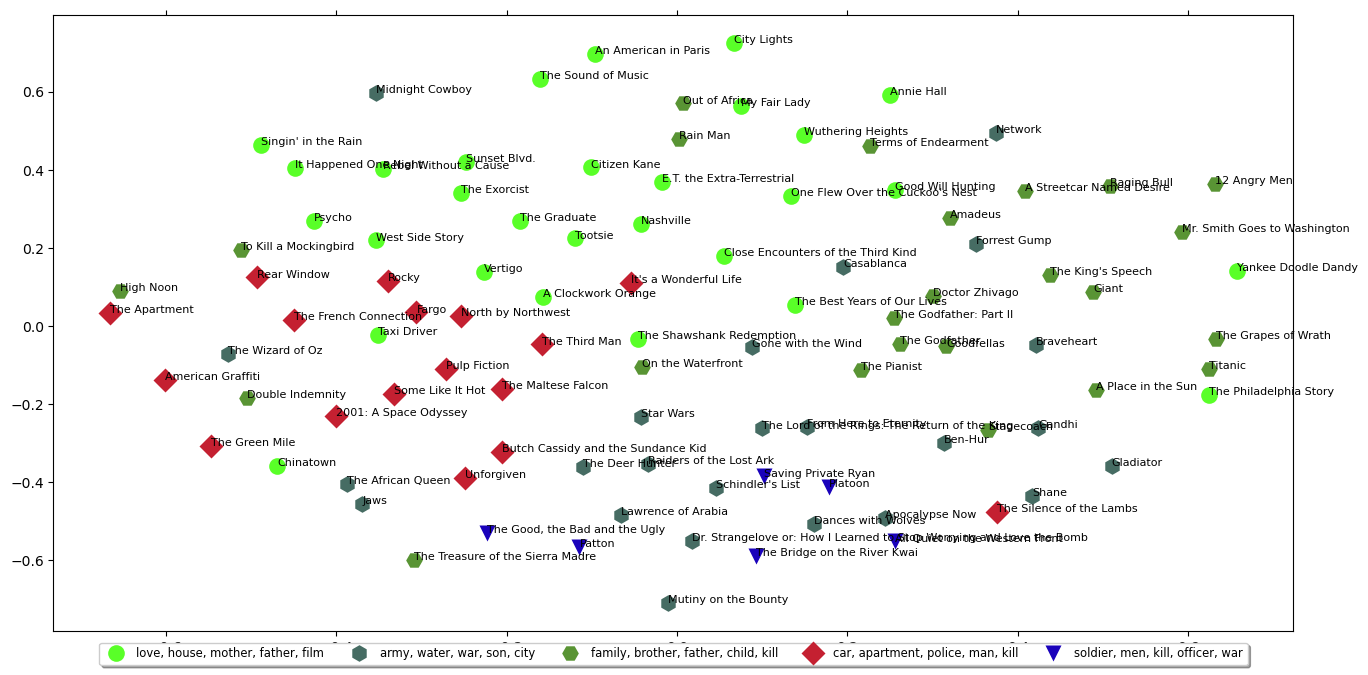

In [22]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8))       
              

### __Affinity Propagation__

Affinity Propagation creates these clusters from the data points by __passing messages__ between pairs
of data points until __convergence is achieved__.<br>

The messages that are sent between pairs represent how suitable one of the points might be in being the
exemplar or representative of the other data point.<br>

The entire dataset is then represented by a small number of __exemplars__(similar to centroids) that act as representatives for samples.  <br>

One __drawback__ of this method is that it is __computationally intensive__ 

In [23]:
def affinity_propagation(feature_matrix):
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    sim = np.asarray(sim)
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_          
    return ap, clusters

In [24]:
#get clusters using affinity propagation
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

In [25]:
#get the total number of movies per cluster
c = Counter(clusters)   
print(c.items())  

dict_items([(0, 5), (2, 12), (5, 10), (11, 4), (1, 6), (16, 7), (3, 6), (13, 7), (4, 7), (7, 4), (8, 8), (12, 5), (10, 2), (6, 7), (14, 4), (15, 3), (9, 3)])


In [26]:
# get total clusters
total_clusters = len(c)
print('Total Clusters:', total_clusters)

Total Clusters: 17


In [27]:
cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=5)         

In [28]:
print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['able', 'always', 'cover', 'end', 'charge']
Movies in this cluster:
The Godfather, The Godfather: Part II, Doctor Zhivago, The Pianist, Goodfellas
Cluster 1 details:
--------------------
Key features: ['alive', 'accept', 'around', 'agree', 'attack']
Movies in this cluster:
Casablanca, One Flew Over the Cuckoo's Nest, Titanic, 2001: A Space Odyssey, The Silence of the Lambs, Good Will Hunting
Cluster 2 details:
--------------------
Key features: ['apartment', 'film', 'final', 'fall', 'due']
Movies in this cluster:
The Shawshank Redemption, Vertigo, West Side Story, Rocky, Tootsie, Nashville, The Graduate, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Rear Window, The Third Man
Cluster 3 details:
--------------------
Key features: ['arrest', 'film', 'evening', 'final', 'fall']
Movies in this cluster:
The Wizard of Oz, Psycho, E.T. the Extra-Terrestrial, My Fair Lady, Ben-Hur, Close Encounters of the Third Kind
Cluster 4 detail

/home/rajneesh/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


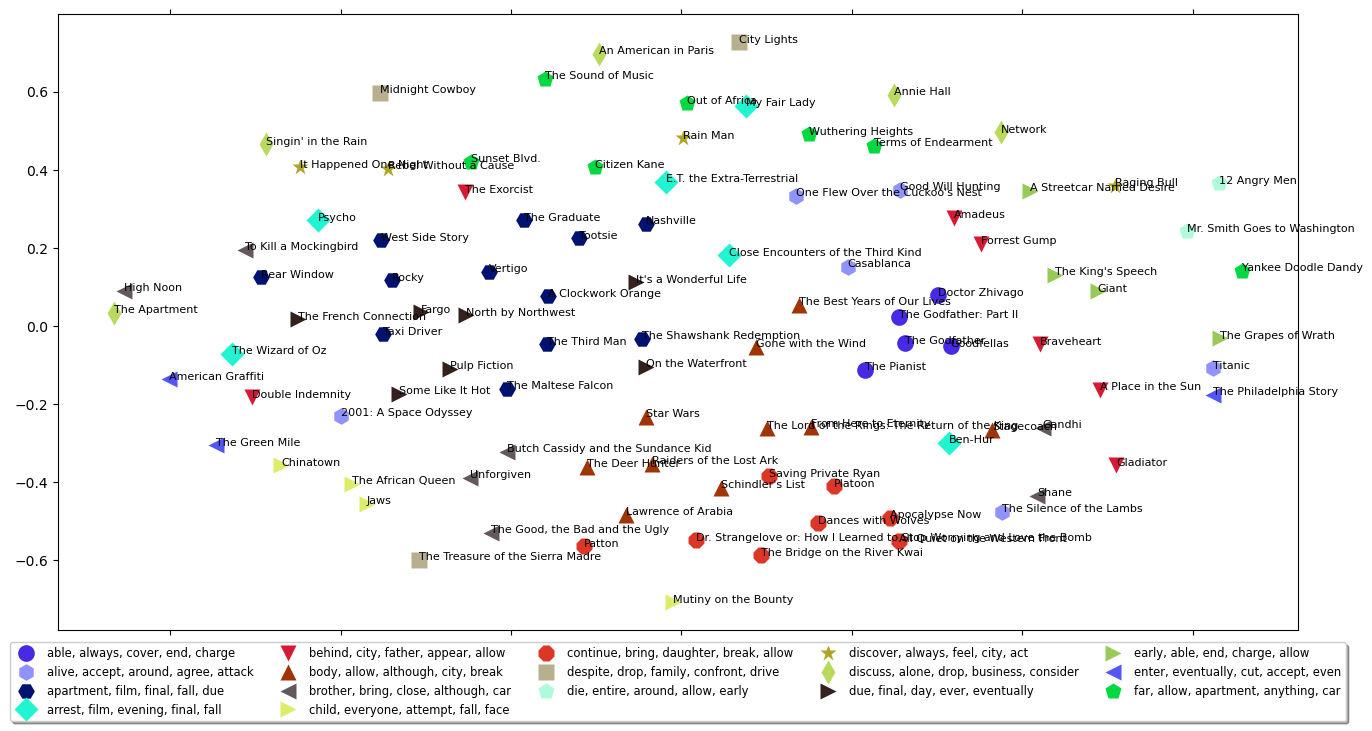

In [29]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 